## Supporting components

### Sigmoid function

In [ ]:
import math

def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))

### Inverse Normal CDF

In [ ]:
import math

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

### Dot product

In [ ]:
from typing import List

Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

assert dot([1, 2, 3], [4, 5, 6]) == 32  # 1 * 4 + 2 * 5 + 3 * 6

### Assignment operator

In [ ]:
tensor = [[1, 2], [3, 4]]

for row in tensor:
    row = [0, 0]
assert tensor == [[1, 2], [3, 4]], "assignment doesn't update a list"

for row in tensor:
    row[:] = [0, 0]
assert tensor == [[0, 0], [0, 0]], "but slice assignment does"

### One-hot encode

In [ ]:
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]

## Tensor

In [ ]:
Tensor = list

In [ ]:
from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensonal (that is, a vector).
    """
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4]]) == 10

from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1, 2, 3]) == [0, 0, 0]
assert zeros_like([[1, 2], [3, 4]]) == [[0, 0], [0, 0]]

def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

import operator
assert tensor_combine(operator.add, [1, 2, 3], [4, 5, 6]) == [5, 7, 9]
assert tensor_combine(operator.mul, [1, 2, 3], [4, 5, 6]) == [4, 10, 18]

## The Layer Abstraction

In [ ]:
from typing import Iterable, Tuple

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params().
        """
        return ()

## Sigmoid Layer

Some layers (for example, a layer that applies sigmoid to each of its inputs) have no parameters to update, so we provide a default implementation that handles that case.

In [ ]:
class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)

## Linear Layer

This layer will have parameters, which we’d like to initialize with random values.

It turns out that the initial parameter values can make a huge difference in how quickly (and sometimes whether) the network trains. If weights are too big, they may produce large outputs in a range where the activation function has near-zero gradients. And parts of the network that have zero gradients necessarily can’t learn anything via gradient descent.

Accordingly, we’ll implement three different schemes for randomly generating our weight tensors. The first is to choose each value from the random uniform distribution on [0, 1]—that is, as a random.random(). The second (and default) is to choose each value randomly from a standard normal distribution. And the third is to use Xavier initialization, where each weight is initialized with a random draw from a normal distribution with mean 0 and variance 2 / (num_inputs + num_outputs). It turns out this often works nicely for neural network weights. We’ll implement these with a random_uniform function and a random_normal function:

In [ ]:
import random

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

And then wrap them all in a random_tensor function:

In [ ]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

Now we can define our linear layer. We need to initialize it with the dimension of the inputs (which tells us how many weights each neuron needs), the dimension of the outputs (which tells us how many neurons we should have), and the initialization scheme we want:

In [ ]:
class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

## Neural Networks as a Sequence of Layers
We’d like to think of neural networks as sequences of layers, so let’s come up with a way to combine multiple layers into one. The resulting neural network is itself a layer, and it implements the Layer methods in the obvious ways:

In [ ]:
class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

So we could represent the neural network we used for XOR as:

In [ ]:
xor_net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1),
    Sigmoid()
])

But we still need a little more machinery to train it.

## Loss

Here we’ll want to experiment with different loss functions, so (as usual) we’ll introduce a new Loss abstraction that encapsulates both the loss computation and the gradient computation:

In [ ]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

### Sum of Squared Loss Function

In [ ]:
class SSE(Loss):
    """Loss function that computes the sum of the squared errors."""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # And just add them up
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)

In [ ]:
sse_loss = SSE()
assert sse_loss.loss([1, 2, 3], [10, 20, 30]) == 9 ** 2 + 18 ** 2 + 27 ** 2
assert sse_loss.gradient([1, 2, 3], [10, 20, 30]) == [-18, -36, -54]

## Optimization
we’ll build a Optimizer abstraction, of which gradient descent will be a specific instance:

In [ ]:
class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

After that it’s easy to implement gradient descent, again using tensor_combine:

In [ ]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

To demonstrate the value of this abstraction, let’s implement another optimizer that uses momentum. The idea is that we don’t want to overreact to each new gradient, and so we maintain a running average of the gradients we’ve seen, updating it with each new gradient and taking a step in the direction of the average:

In [ ]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

## XOR Model

In [ ]:
import tqdm

# training data
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

random.seed(0)

net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1)
])

optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()

with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)

            optimizer.step(net)

        t.set_description(f"xor loss {epoch_loss:.3f}")

xor loss 0.000: 100%|██████████| 3000/3000 [00:07<00:00, 403.38it/s]


In [ ]:
for param in net.params():
    print(param)

[[-1.6425160695224101, -1.4948117798303153], [-4.567646572029667, -3.3649176350731924]]
[1.7673716823255166, 0.38727014379473046]
[[3.198620479170406, -3.5018030621426175]]
[-0.6462765963362207]


In [ ]:
x1 = 0
x2 = 0

w_h1x1 = -1.64
w_h1x2 = -1.49
w_h2x1 = -4.57
w_h2x2 = -3.36

w_h1o = 1.77
w_h2o = 0.39

b_h1 = 3.2
b_h2 = -3.5

b_o = -0.65

h1 = w_h1x1 * x1 + w_h1x2 * x2 + b_h1
h2 = w_h2x1 * x1 + w_h2x2 * x2 + b_h2

output = w_h1o * h1 + w_h2o * h2 + b_o
output

3.6490000000000005

In [ ]:
h1 = -2.6 * x1 + -2.7 * x2 + 0.2  # NOR
h2 =  2.1 * x1 +  2.1 * x2 - 3.4  # AND
output =  -3.1 * h1 + -2.6 * h2 + 1.8  # NOR
output

10.02

## Other Activation Functions
The sigmoid function has fallen out of favor for a couple of reasons. One reason is that sigmoid(0) equals 1/2, which means that a neuron whose inputs sum to 0 has a positive output. Another is that its gradient is very close to 0 for very large and very small inputs, which means that its gradients can get “saturated” and its weights can get stuck.

One popular replacement is tanh (“hyperbolic tangent”), which is a different sigmoid-shaped function that ranges from –1 to 1 and outputs 0 if its input is 0. The derivative of tanh(x) is just 1 - tanh(x) ** 2, which makes the layer easy to write:

In [ ]:
import math

def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because e.g. math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass.
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)

In larger networks another popular replacement is Relu, which is 0 for negative inputs and the identity for positive inputs:

In [ ]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

## FizzBuzz

In [ ]:
def binary_encode(x: int) -> Vector:
    binary: List[float] = []

    for i in range(10):
        binary.append(x % 2)
        x = x // 2

    return binary

#                             1  2  4  8 16 32 64 128 256 512
assert binary_encode(0)   == [0, 0, 0, 0, 0, 0, 0, 0,  0,  0]
assert binary_encode(1)   == [1, 0, 0, 0, 0, 0, 0, 0,  0,  0]
assert binary_encode(10)  == [0, 1, 0, 1, 0, 0, 0, 0,  0,  0]
assert binary_encode(101) == [1, 0, 1, 0, 0, 1, 1, 0,  0,  0]
assert binary_encode(999) == [1, 1, 1, 0, 0, 1, 1, 1,  1,  1]

In [ ]:
def argmax(xs: list) -> int:
    """Returns the index of the largest value"""
    return max(range(len(xs)), key=lambda i: xs[i])

assert argmax([0, -1]) == 0               # items[0] is largest
assert argmax([-1, 0]) == 1               # items[1] is largest
assert argmax([-1, 10, 5, 20, -3]) == 3   # items[3] is largest

In [ ]:
def fizz_buzz_encode(x: int) -> Vector:
    if x % 15 == 0:
        return [0, 0, 0, 1]
    elif x % 5 == 0:
        return [0, 0, 1, 0]
    elif x % 3 == 0:
        return [0, 1, 0, 0]
    else:
        return [1, 0, 0, 0]

assert fizz_buzz_encode(2) == [1, 0, 0, 0]
assert fizz_buzz_encode(6) == [0, 1, 0, 0]
assert fizz_buzz_encode(10) == [0, 0, 1, 0]
assert fizz_buzz_encode(30) == [0, 0, 0, 1]

In [ ]:
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

NUM_HIDDEN = 25

random.seed(0)

net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
    Sigmoid()
])

def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
    num_correct = 0
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        if predicted == actual:
            num_correct += 1

    return num_correct / (hi - low)

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()

with tqdm.trange(1000) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)

            optimizer.step(net)

        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")

# Now check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 64.54 acc: 0.95: 100%|██████████| 1000/1000 [10:06<00:00,  1.65it/s]

test results 0.9


## Softmaxes and Cross-Entropy
The neural net we used in the previous section ended in a Sigmoid layer, which means that its output was a vector of numbers between 0 and 1. In particular, it could output a vector that was entirely 0s, or it could output a vector that was entirely 1s. Yet when we’re doing classification problems, we’d like to output a 1 for the correct class and a 0 for all the incorrect classes. Generally our predictions will not be so perfect, but we’d at least like to predict an actual probability distribution over the classes.

For example, if we have two classes, and our model outputs [0, 0], it’s hard to make much sense of that. It doesn’t think the output belongs in either class?

But if our model outputs [0.4, 0.6], we can interpret it as a prediction that there’s a probability of 0.4 that our input belongs to the first class and 0.6 that our input belongs to the second class.

In order to accomplish this, we typically forgo the final Sigmoid layer and instead use the softmax function, which converts a vector of real numbers to a vector of probabilities. We compute exp(x) for each number in the vector, which results in a vector of positive numbers. After that, we just divide each of those positive numbers by the sum, which gives us a bunch of positive numbers that add up to 1—that is, a vector of probabilities.

In [ ]:
def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stability.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight."
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

Once our network produces probabilities, we often use a different loss function called cross-entropy (or sometimes “negative log likelihood”).

If our network outputs are probabilities, the cross-entropy loss represents the negative log likelihood of the observed data, which means that minimizing that loss is the same as maximizing the log likelihood (and hence the likelihood) of the training data.

Typically we won’t include the softmax function as part of the neural network itself. This is because it turns out that if softmax is part of your loss function but not part of the network itself, the gradients of the loss with respect to the network outputs are very easy to compute.

In [ ]:
class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

## FizzBuzz Revisited

If I now train the same Fizz Buzz network using SoftmaxCrossEntropy loss, I find that it typically trains much faster (that is, in many fewer epochs). Presumably this is because it is much easier to find weights that softmax to a given distribution than it is to find weights that sigmoid to a given distribution.

That is, if I need to predict class 0 (a vector with a 1 in the first position and 0s in the remaining positions), in the linear + sigmoid case I need the first output to be a large positive number and the remaining outputs to be large negative numbers. In the softmax case, however, I just need the first output to be larger than the remaining outputs. Clearly there are a lot more ways for the second case to happen, which suggests that it should be easier to find weights that make it so:

In [ ]:
random.seed(0)

net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
    # No final sigmoid layer now
])

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(100) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)

            optimizer.step(net)

        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")

# Again check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 6.116 acc: 1.00: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

test results 0.97


## Dropout
A common way of regularizing neural networks is using dropout. At training time, we randomly turn off each neuron (that is, replace its output with 0) with some fixed probability. This means that the network can’t learn to depend on any individual neuron, which seems to help with overfitting.

At evaluation time, we don’t want to dropout any neurons, so a Dropout layer will need to know whether it’s training or not. In addition, at training time a Dropout layer only passes on some random fraction of its input. To make its output comparable during evaluation, we’ll scale down the outputs (uniformly) using that same fraction:

In [ ]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")

## MNIST

MNIST is a dataset of handwritten digits that everyone uses to learn deep learning.

It is available in a somewhat tricky binary format, so we’ll install the mnist library to work with it. (Yes, this part is technically not “from scratch.”)

In [ ]:
!pip install -q mnist

In [ ]:
import mnist

# This will download the data; change this to where you want it.
# (Yes, it's a 0-argument function, that's what the library expects.)
# (Yes, I'm assigning a lambda to a variable, like I said never to do.)
mnist.temporary_dir = lambda: '/tmp'

# Each of these functions first downloads the data and returns a numpy array.
# We call .tolist() because our "tensors" are just lists.
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

assert shape(train_images) == [60000, 28, 28]
assert shape(train_labels) == [60000]

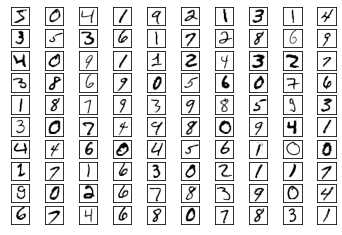

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 10)

for i in range(10):
    for j in range(10):
        # Plot each image in black and white and hide the axes.
        ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)

plt.show()

We also need to load the test images:

In [ ]:
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()

assert shape(test_images) == [10000, 28, 28]
assert shape(test_labels) == [10000]

In [ ]:
# Recenter the images

# Compute the average pixel value
avg = tensor_sum(train_images) / 60000 / 28 / 28

# Recenter, rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in train_images]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in test_images]

assert shape(train_images) == [60000, 784], "images should be flattened"
assert shape(test_images) == [10000, 784], "images should be flattened"

# After centering, average pixel should be very close to 0
assert -0.0001 < tensor_sum(train_images) < 0.0001


# One-hot encode the test data

train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]

assert shape(train_labels) == [60000, 10]
assert shape(test_labels) == [10000, 10]


# Training loop

import tqdm

def loop(model: Layer,
            images: List[Tensor],
            labels: List[Tensor],
            loss: Loss,
            optimizer: Optimizer = None) -> None:
    correct = 0         # Track number of correct predictions.
    total_loss = 0.0    # Track total loss.

    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])             # Predict.
            if argmax(predicted) == argmax(labels[i]):       # Check for
                correct += 1                                 # correctness.
            total_loss += loss.loss(predicted, labels[i])    # Compute loss.

            # If we're training, backpropagate gradient and update weights.
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)

            # And update our metrics in the progress bar.
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

### The logistic regression model for MNIST

In [ ]:
random.seed(0)

# Logistic regression is just a linear layer followed by softmax
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()

# This optimizer seems to work
optimizer = Momentum(learning_rate=0.01, momentum=0.99)

# Train on the training data
loop(model, train_images, train_labels, loss, optimizer)

# Test on the test data (no optimizer means just evaluate)
loop(model, test_images, test_labels, loss)

mnist loss: 0.361 acc: 0.891: 100%|██████████| 10000/10000 [00:41<00:00, 241.92it/s]


### A deep neural network for MNIST

In [ ]:
random.seed(0)

# Name them so we can turn train on and off
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)

model = Sequential([
    Linear(784, 30),  # Hidden layer 1: size 30
    dropout1,
    Tanh(),
    Linear(30, 10),   # Hidden layer 2: size 10
    dropout2,
    Tanh(),
    Linear(10, 10)    # Output layer: size 10
])


# Training the deep model for MNIST

optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()

# Enable dropout and train (takes > 20 minutes on my laptop!)
dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)

# Disable dropout and evaluate
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

mnist loss: 0.313 acc: 0.908: 100%|██████████| 10000/10000 [01:13<00:00, 136.94it/s]
